# Chapter 4.4 単回帰

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## データ
- ある架空の会社の社員の年収データ
- X:年齢
- Y:年収
- 年齢から年収を推定したい

In [2]:
d = pd.read_csv('chap04/input/data-salary.txt')
print(d.shape)
d.head()

(20, 2)


,X,Y
0,24,472
1,24,403
2,26,454
3,32,575
4,33,546


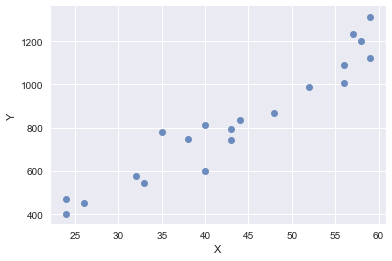

In [3]:
sns.regplot(x='X', y='Y', data=d, fit_reg=False)
plt.show()

## モデル

$Y[n]$ ~ $Normal( a + bX[n], \sigma)$

In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 

C:\Users\eX\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 線形モデル

In [5]:
res_lm = smf.ols(formula='Y ~ X', data=d).fit()
res_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     208.2
Date:                Wed, 02 May 2018   Prob (F-statistic):           2.47e-11
Time:                        14:06:54   Log-Likelihood:                -114.74
No. Observations:                  20   AIC:                             233.5
Df Residuals:                      18   BIC:                             235.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -119.6971     68.148     -1.756      0.096    -262.871      23.477
X             21.9042      1.518     14.428      0.000      18.715      25.094
==============================================================================
Omnibus:                        0.099   Durbin-Watson:                   2.252
Prob(Omnibus):                  0.952   Jarque-Bera (JB):                0.216
Skew:                           0.140   Prob(JB):                        0.898
Kurtosis:                       2.575   Cond. No.                         173.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

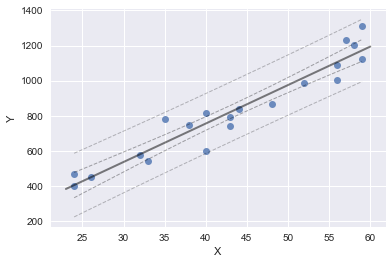

In [6]:
from statsmodels.stats.outliers_influence import summary_table
st, data, ss2 = summary_table(res_lm, alpha=0.05)
fittedvalues = data[:,2]
predict_mean_se  = data[:,3]
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T
predict_ci_low, predict_ci_upp = data[:,6:8].T

X_new = pd.DataFrame(data={'X':range(23,61)})
pred = res_lm.predict(exog=X_new)

sns.regplot(x=d.X, y=d.Y, fit_reg=False)
plt.plot(X_new, pred, 'k-', lw=2, alpha=1/2)
# 信頼区間
plt.plot(d.X, predict_mean_ci_low, 'k--', lw=1, alpha=1/3)
plt.plot(d.X, predict_mean_ci_upp, 'k--', lw=1, alpha=1/3)
# 予測区間
plt.plot(d.X, predict_ci_low, 'k--', lw=1, alpha=1/4)
plt.plot(d.X, predict_ci_upp, 'k--', lw=1, alpha=1/4)
plt.show()

## Stan で実装

In [8]:
from pystan import StanModel

sm = StanModel(file='chap04/model/model4-5.stan')
data = {'N': d.shape[0], 'X': d.X, 'Y': d.Y}
fit = sm.sampling(data=data, seed=1234, n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a5383320e5d818d976e59523c8e84c3c NOW.


In [9]:
ms = fit.extract()
fit

Inference for Stan model: anon_model_a5383320e5d818d976e59523c8e84c3c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a     -119.3    2.18  73.62 -264.6 -166.8 -118.7 -73.41  26.42   1144    1.0
b      21.89    0.05   1.65  18.59  20.84   21.9  22.93  25.14   1150    1.0
sigma  86.13    0.41  16.05  61.93  74.79  83.77  94.84 122.39   1498    1.0
lp__   -93.7    0.04   1.37 -97.23 -94.32 -93.34 -92.71 -92.16   1043    1.0

Samples were drawn using NUTS at Wed May  2 14:07:46 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

## ファイル出力

In [10]:
import pickle

if not os.path.exists('my_output'):
    os.makedirs(name='my_output')

with open('my_output/ch04-4_model_and_result.pkl', 'wb') as f:
    pickle.dump(sm, f, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(fit, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('my_output/ch04-4_fit-summary.txt', 'w') as f:
    f.write(str(fit))

C:\Users\eX\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.


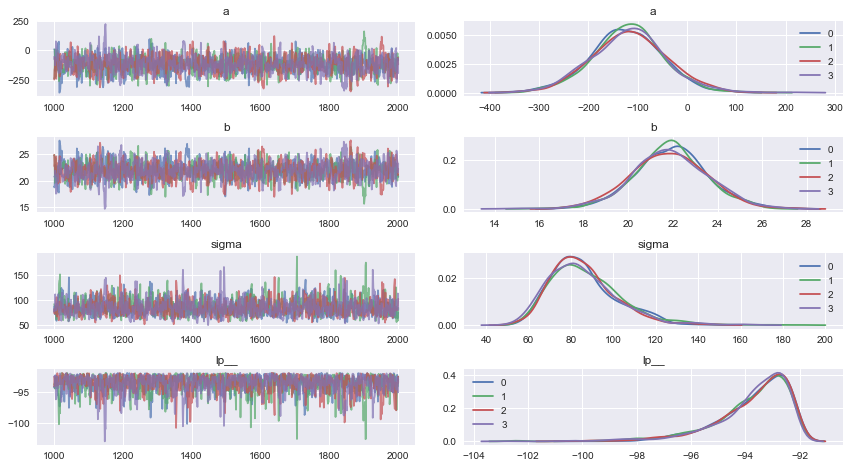

In [11]:
## traceplot
import math

palette = sns.color_palette()
ms = fit.extract(permuted=False, inc_warmup=True)
iter_from = fit.sim['warmup']
iter_range = np.arange(iter_from, ms.shape[0])
paraname = fit.sim['fnames_oi'][:9]
gpp = 5 # 画像１枚あたりの縦方向のグラフ数 gpp:graph per page
num_pages = math.ceil(len(paraname)/gpp)  # parameter 数をgppで割った数より大きい最少の整数=画像枚数

for pg in range(num_pages):  # 1ページにgppx2のグラフをプロットする
    plt.figure(figsize=(12,8))
    for pos in range(gpp):
        pi = pg*4 + pos
        if pi >= len(paraname): break
        # trace plot
        plt.subplot(gpp, 2, 2*pos+1)
        plt.tight_layout()
        [plt.plot(iter_range + 1, ms[iter_range,ci,pi], color=palette[ci], label=ci, alpha=.7) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
        # posterior distribution 
        plt.subplot(gpp, 2, 2*(pos+1))
        plt.tight_layout()
        [sns.kdeplot(ms[iter_range,ci,pi], color=palette[ci], label=ci) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
        plt.legend()

In [12]:
## traceplot
import math

def draw_trace_plot(fit):
    """ trace plot を作図するところはよく使うので関数化しておく

    fit(obj): pystan fit instance
    
    return
    """
    palette = sns.color_palette()
    ms = fit.extract(permuted=False, inc_warmup=True)
    iter_from = fit.sim['warmup']
    iter_range = np.arange(iter_from, ms.shape[0])
    paraname = fit.sim['fnames_oi'][:9]
    gpp = 5 # 画像１枚あたりの縦方向のグラフ数 gpp:graph per page
    num_pages = math.ceil(len(paraname)/gpp)  # parameter 数をgppで割った数より大きい最少の整数=画像枚数

    for pg in range(num_pages):  # 1ページにgppx2のグラフをプロットする
        plt.figure(figsize=(12,8))
        for pos in range(gpp):
            pi = pg*4 + pos
            if pi >= len(paraname): break
            # trace plot
            plt.subplot(gpp, 2, 2*pos+1)
            plt.tight_layout()
            [plt.plot(iter_range + 1, ms[iter_range,ci,pi], color=palette[ci], label='chain: '+str(ci), alpha=.7) for ci in range(ms.shape[1])]
            plt.title(paraname[pi])
            # posterior distribution 
            plt.subplot(gpp, 2, 2*(pos+1))
            plt.tight_layout()
            [sns.kdeplot(ms[iter_range,ci,pi], color=palette[ci], label='chain: '+str(ci)) for ci in range(ms.shape[1])]
            plt.title(paraname[pi])
            plt.legend()
    plt.show()

## MCMC の設定変更

In [13]:
def initfun1():
    """変数初期値を与えるdictを返す"""
    return dict(a=np.random.uniform(0, 10), b=np.random.uniform(0, 100), sigma=10)

fit = sm.sampling(data=data, 
                  pars=['a', 'b', 'sigma'],
                  init=initfun1,
                  seed=123,
                  chains=6, iter=1000, warmup=200, thin=2,  n_jobs=1
                 )

In [14]:
initfun1()

{'a': 7.41168668904835, 'b': 34.05742934723052, 'sigma': 10}

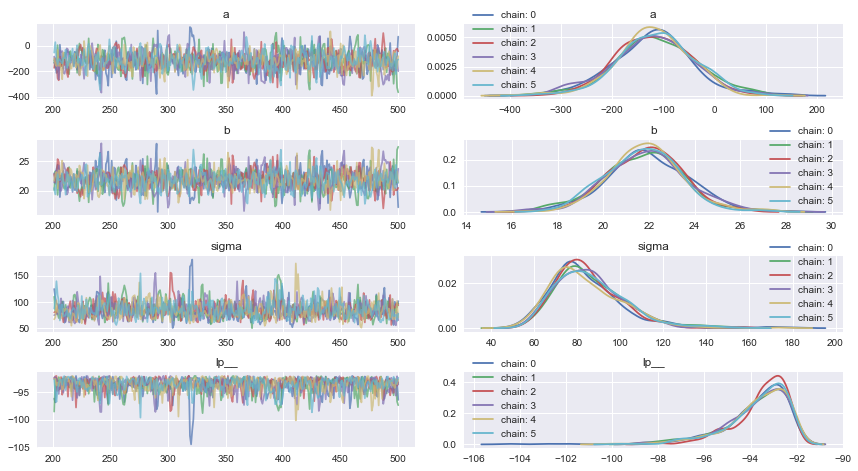

In [15]:
draw_trace_plot(fit=fit)

In [16]:
ms = fit.extract()

ms['b'].shape # chains * (iter - warmup) / thin

(2400,)

In [17]:
np.percentile(ms['b'], [2.5, 97.5])

array([ 18.64074598,  25.22148831])

In [18]:
d_mcmc = pd.DataFrame({'a':ms['a'], 'b':ms['b'], 'sigma':ms['sigma']})
d_mcmc.head()

,a,b,sigma
0,-94.538278,20.905296,60.170886
1,-90.311246,20.992404,75.917534
2,-29.840007,19.667916,83.902275
3,-122.877478,21.244185,79.675288
4,-129.143792,22.279253,92.386655


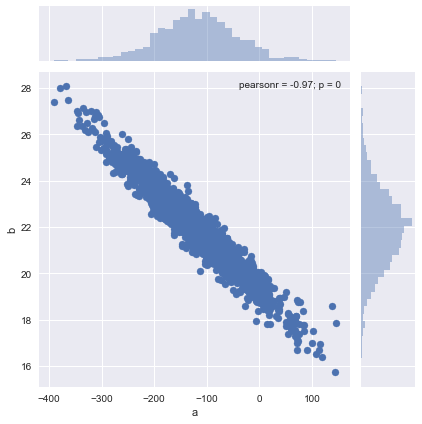

In [19]:
sns.jointplot(x=d_mcmc.a, y=d_mcmc.b, )

In [20]:
N_mcmc = len(ms['lp__'])
y50_base = ms['a'] + ms['b'] * 50
y50 = np.random.normal(loc=y50_base, scale=ms['sigma'])
d_mcmc['y50_base'] = y50_base
d_mcmc['y50'] = y50
d_mcmc.head()

,a,b,sigma,y50_base,y50
0,-94.538278,20.905296,60.170886,950.726544,967.415497
1,-90.311246,20.992404,75.917534,959.308972,913.241577
2,-29.840007,19.667916,83.902275,953.555803,1023.206459
3,-122.877478,21.244185,79.675288,939.331786,942.485861
4,-129.143792,22.279253,92.386655,984.818845,1134.235102


## generated quantities

In [21]:
sm = StanModel(file='chap04/model/model4-4.stan')
data = dict(N=d.shape[0], X=d.X, Y=d.Y, N_new=X_new.shape[0], X_new=X_new.X)
fit = sm.sampling(data=data, seed=1234)
ms = fit.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_703efebef0fb1f70bba7c6f9021a3eda NOW.


In [22]:
ms.keys()

odict_keys(['a', 'b', 'sigma', 'y_base', 'y_base_new', 'y_new', 'lp__'])

信頼区間

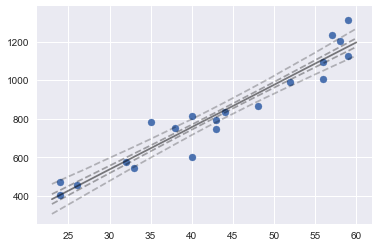

In [23]:
qua = np.percentile(ms['y_base_new'], q=[2.5, 25, 50, 75, 97.5], axis=0)
d_qua = pd.DataFrame(qua.T, 
                     columns=['p'+str(p) for p in [2.5, 25, 50, 75, 97.5]],
                    index=X_new.X)
d_qua.reset_index(inplace=True)

plt.plot(d_qua.X, d_qua['p2.5'], 'k--', alpha=1/4)
plt.plot(d_qua.X, d_qua['p25'], 'k--', alpha=1/3)
plt.plot(d_qua.X, d_qua['p50'], 'k-', alpha=1/2)
plt.plot(d_qua.X, d_qua['p75'], 'k--', alpha=1/3)
plt.plot(d_qua.X, d_qua['p97.5'], 'k--', alpha=1/4)
plt.scatter(d.X, d.Y)

予測区間

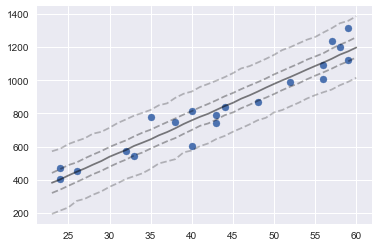

In [24]:
qua = np.percentile(ms['y_new'], q=[2.5, 25, 50, 75, 97.5], axis=0)
d_qua = pd.DataFrame(qua.T, 
                     columns=['p'+str(p) for p in [2.5, 25, 50, 75, 97.5]],
                    index=X_new.X)
d_qua.reset_index(inplace=True)

plt.plot(d_qua.X, d_qua['p2.5'], 'k--', alpha=1/4)
plt.plot(d_qua.X, d_qua['p25'], 'k--', alpha=1/3)
plt.plot(d_qua.X, d_qua['p50'], 'k-', alpha=1/2)
plt.plot(d_qua.X, d_qua['p75'], 'k--', alpha=1/3)
plt.plot(d_qua.X, d_qua['p97.5'], 'k--', alpha=1/4)
plt.scatter(d.X, d.Y)